# Transfer Learning for Classifying Politicians 

Since the politicians dataset is rather small, we would like to use a pre-trained network for our classification. However, the question asked is weather to use **all** the layers or just **part** of them as a strating point for out task. Another question raised here is weather to keep them **fix** or **fine-tune** them.

In this assignment we will dive into these questions (does is sound familiar to you? this is what the paper from research seminar is about).




In [ ]:
%matplotlib inline


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()   # interactive mode
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

### Loading the Data


In [ ]:
# Create a folder for our data
# The ! prefix runs this as a shell command
!mkdir data
!mkdir data/israeli_politicians

In [ ]:
# Download our dataset and extract it
import requests
from zipfile import ZipFile

url = 'https://github.com/omriallouche/ydata_deep_learning_2021/blob/main/data/israeli_politicians.zip?raw=true'
r = requests.get(url, allow_redirects=True)
open('./data/israeli_politicians.zip', 'wb').write(r.content)

with ZipFile('./data/israeli_politicians.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path='./data/israeli_politicians/')

### Datasets Loader


In [ ]:
# Define transformations that resize the images to 256x256, and normalize them. 
# The means and standard deviations of each channel are the values used for normalization in ImageNet
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}

In [ ]:
data_dir = r'./data/israeli_politicians/'

# Create a dictionary of train and val datasets from images in folders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16,
                                             shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=16,
                                          shuffle=False, num_workers=4)
  }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print('dataset_sizes: ', dataset_sizes)

class_names = image_datasets['train'].classes
print('class_names:', class_names)

dataset_sizes:  {'train': 929, 'val': 234}
class_names: ['ayelet_shaked', 'benjamin_netanyahu', 'benny_gantz', 'danny_danon', 'gideon_saar', 'kostya_kilimnik', 'naftali_bennett', 'ofir_akunis', 'yair_lapid']


In [ ]:
# Check for the availability of a GPU, and use CPU otherwise
# If you are using Google Colab, be sure to change your runtime environment to GPU first.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



In [ ]:
# A helper function to show an image from a tensor. We need to restore it to the original dynamic range before normalization
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(means)
    std = np.array(stds)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
# Get a batch of training data - the data loader is a generator
inputs, classes = next(iter(dataloaders['train']))

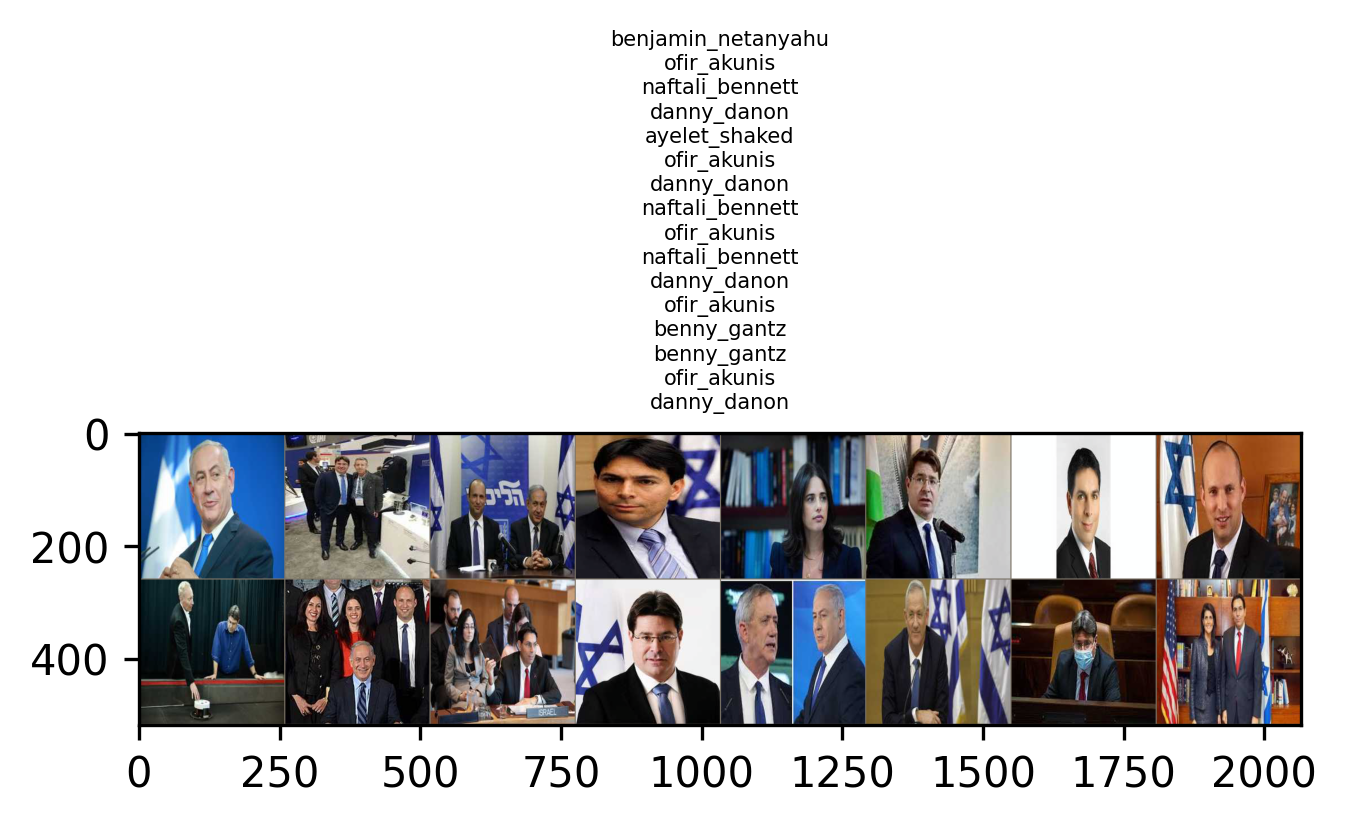

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)

imshow(out, title='\n'.join([class_names[x] for x in classes]))

In [ ]:
import copy
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            dict_res[phase][0,epoch]=epoch_loss
            dict_res[phase][1,epoch]=epoch_acc

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, dict_res


## Using a pretrained model - finetune all layers

This was the first task of the course, loading a model pretrained on ImageNet, and use it for our task.  
We will use the VGG16 network, that won the ImageNet Challenge in 2016 and change the last linear layer to 9 output features:

In [ ]:
# We load a pretrain model with its weights. Alternatively, one might want to only load the model architecture.
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=9)

Let's review our change in the model:

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
!pip install torchsummary 
from torchsummary import summary
summary(model.to(device), (3, 256, 256))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
    

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 10

In [ ]:
%%time 
model,dict_res = train_model(model.to('cuda'), 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 1.7264 Acc: 0.3811
val Loss: 1.3491 Acc: 0.5000

Epoch 1/9
----------
train Loss: 1.0337 Acc: 0.6426
val Loss: 0.9495 Acc: 0.6709

Epoch 2/9
----------
train Loss: 0.6044 Acc: 0.7933
val Loss: 0.9256 Acc: 0.7009

Epoch 3/9
----------
train Loss: 0.2269 Acc: 0.9117
val Loss: 0.7842 Acc: 0.7949

Epoch 4/9
----------
train Loss: 0.1043 Acc: 0.9709
val Loss: 0.8752 Acc: 0.7778

Epoch 5/9
----------
train Loss: 0.1927 Acc: 0.9408
val Loss: 0.6615 Acc: 0.8120

Epoch 6/9
----------
train Loss: 0.1355 Acc: 0.9645
val Loss: 0.9823 Acc: 0.7308

Epoch 7/9
----------
train Loss: 0.1176 Acc: 0.9709
val Loss: 0.7381 Acc: 0.7863

Epoch 8/9
----------
train Loss: 0.0420 Acc: 0.9925
val Loss: 0.7275 Acc: 0.7991

Epoch 9/9
----------
train Loss: 0.0306 Acc: 0.9946
val Loss: 0.7410 Acc: 0.7991

Training complete in 3m 27s
Best val Acc: 0.811966
CPU times: user 2min 49s, sys: 5.83 s, total: 2min 55s
Wall time: 3min 26s


In [ ]:
def plot_convergence(dict_res, num_epochs):
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  types=['Loss', 'Accuracy']
  plt.subplot(1,2,1); plt.plot(dict_res['train'][0],'*-'); plt.plot(dict_res['val'][0],'*-'); plt.title('Loss'); plt.legend(['train','val'])  ; plt.xlabel('epoch num')
  plt.subplot(1,2,2); plt.plot(dict_res['train'][1] ,'*-'); plt.plot(dict_res['val'][1],'*-'); plt.title('Accuracy'); plt.legend(['train','val']) ; plt.xlabel('epoch num')


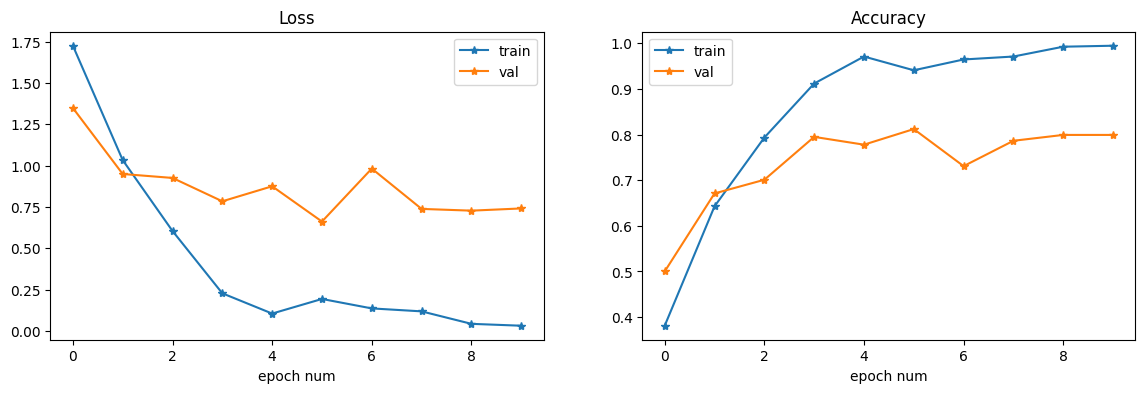

In [ ]:
plot_convergence(dict_res,num_epochs ); plt.show()
#0.833 - this is not a bad result:) fine tune all the layers didn't took much time so it might be a very good stratagy in our case.
# following the plots below a few more epochs might be needed to reach (see) the "plato"
'''CPU times: user 2min 49s, sys: 5.83 s, total: 2min 55s
Wall time: 3min 26s'''

## (1) Using a pretrained model - fixed NN feature (30 points)
Use pre-trained VGG16 model with fixed weights of all layers (up to the last one, of course).

**Do not forget to load the model again, otherwise the training will start from where the last training stopped**

##Answer:
 we will change the training function such that it will keep all vgg16 layers fix expect the last layer:


In [ ]:
# modify for freezing all layers but the last #
###############################################
def train_model_1(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # --Freeze all layers except to the last layer--#
    for param in model.features[:-1].parameters():
      param.requires_grad = False

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            dict_res[phase][0,epoch]=epoch_loss
            dict_res[phase][1,epoch]=epoch_acc

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, dict_res


In [ ]:
# init model
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=9)

In [ ]:
# init model param
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 20  # update to 20 epoch for easy comparison to next questions and models

In [ ]:
# training (all freezed but last layer)
%%time 
model_1,dict_res = train_model_1(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 1.8265 Acc: 0.3348
val Loss: 1.5852 Acc: 0.4444

Epoch 1/19
----------
train Loss: 1.3536 Acc: 0.5447
val Loss: 1.3515 Acc: 0.5556

Epoch 2/19
----------
train Loss: 0.9823 Acc: 0.6706
val Loss: 1.1897 Acc: 0.5983

Epoch 3/19
----------
train Loss: 0.7345 Acc: 0.7847
val Loss: 1.1183 Acc: 0.6282

Epoch 4/19
----------
train Loss: 0.5138 Acc: 0.8439
val Loss: 1.0961 Acc: 0.6624

Epoch 5/19
----------
train Loss: 0.3755 Acc: 0.8859
val Loss: 1.0895 Acc: 0.6709

Epoch 6/19
----------
train Loss: 0.2641 Acc: 0.9290
val Loss: 1.1955 Acc: 0.6538

Epoch 7/19
----------
train Loss: 0.2229 Acc: 0.9408
val Loss: 1.0721 Acc: 0.6667

Epoch 8/19
----------
train Loss: 0.1809 Acc: 0.9580
val Loss: 1.0642 Acc: 0.6795

Epoch 9/19
----------
train Loss: 0.1679 Acc: 0.9634
val Loss: 1.0637 Acc: 0.6752

Epoch 10/19
----------
train Loss: 0.1651 Acc: 0.9623
val Loss: 1.0653 Acc: 0.6838

Epoch 11/19
----------
train Loss: 0.1575 Acc: 0.9645
val Loss: 1.0699 Acc: 0.6795

Ep

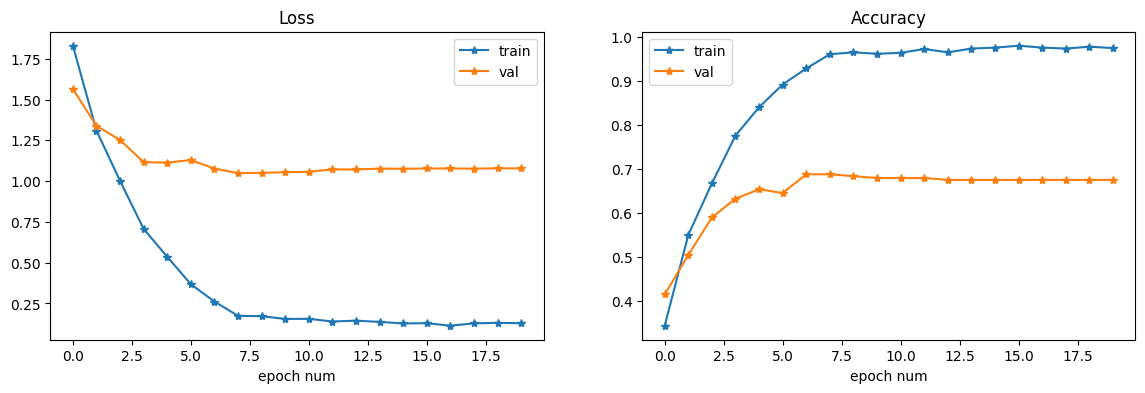

In [ ]:
# plotting
plot_convergence(dict_res,num_epochs); plt.show()
# training 20 epochs when 
# same time for X2 epochs:
'''CPU times: user 2min 21s, sys: 11.3 s, total: 2min 32s
Wall time: 3min 23s'''

## Conclusions:
We can see that freezing all layers but the last one approach results in a less acurate model than finetuning all layers. 
Here we got acuracy of 0.667 compare to 0.816 in the previous section. we can further see that training 20 epochs was much faster when most of the layers are frozen rather than finetune all (trade-of)

## (2) Using a pretrained model - fixed some feature, tine-tune the rest (30 points)

Use pre-trained VGG16 model with fixed weights of **only part of the layers**. **Fine-tune** the rest of the layers. You should try different amount of layers as you wish. Try to get your best results.

In [ ]:
# modify for freezing some first layers 
def train_model_2(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Freezing up to :28 layer
    for param in model.features[:28].parameters():
      param.requires_grad = False

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            dict_res[phase][0,epoch]=epoch_loss
            dict_res[phase][1,epoch]=epoch_acc

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, dict_res


In [ ]:
# init model
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=9)

In [ ]:
# init model param
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 20

In [ ]:
# training when layers [:28] are freezed:
%%time
model_2,dict_res = train_model_2(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 1.8335 Acc: 0.3348
val Loss: 1.4818 Acc: 0.5171

Epoch 1/19
----------
train Loss: 1.2264 Acc: 0.5845
val Loss: 1.1938 Acc: 0.5812

Epoch 2/19
----------
train Loss: 0.7815 Acc: 0.7492
val Loss: 1.0595 Acc: 0.6410

Epoch 3/19
----------
train Loss: 0.4770 Acc: 0.8461
val Loss: 0.9581 Acc: 0.7137

Epoch 4/19
----------
train Loss: 0.3069 Acc: 0.9139
val Loss: 0.9969 Acc: 0.7009

Epoch 5/19
----------
train Loss: 0.1929 Acc: 0.9429
val Loss: 0.9734 Acc: 0.7051

Epoch 6/19
----------
train Loss: 0.1305 Acc: 0.9656
val Loss: 0.9659 Acc: 0.7179

Epoch 7/19
----------
train Loss: 0.0757 Acc: 0.9871
val Loss: 0.9158 Acc: 0.7265

Epoch 8/19
----------
train Loss: 0.0687 Acc: 0.9849
val Loss: 0.9231 Acc: 0.7222

Epoch 9/19
----------
train Loss: 0.0658 Acc: 0.9882
val Loss: 0.9328 Acc: 0.7265

Epoch 10/19
----------
train Loss: 0.0591 Acc: 0.9892
val Loss: 0.9352 Acc: 0.7350

Epoch 11/19
----------
train Loss: 0.0531 Acc: 0.9914
val Loss: 0.9452 Acc: 0.7265

Ep

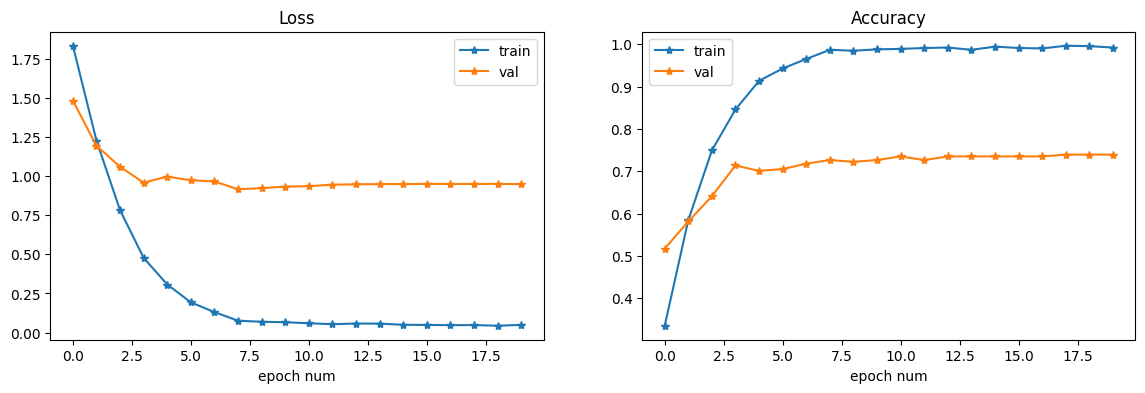

In [ ]:
#plot
# accuracy = 0.73 (not as good as finetune all layers)
plot_convergence(dict_res,num_epochs ); plt.show()

In [ ]:
# lets try and freeze only first two layers and finetune the rest:

In [ ]:
# modify for freezing  first two conv layers 
def train_model_2(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Freezing up to :2 conv layers
    for param in model.features[:4].parameters():
      param.requires_grad = False

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            dict_res[phase][0,epoch]=epoch_loss
            dict_res[phase][1,epoch]=epoch_acc

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, dict_res


In [ ]:
# init model
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=9)

In [ ]:
# init model param
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 20

In [ ]:
# training when layers [:4] are freezed:
%%time
model_2,dict_res = train_model_2(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 1.8144 Acc: 0.3671
val Loss: 1.6017 Acc: 0.3974

Epoch 1/19
----------
train Loss: 1.1250 Acc: 0.5963
val Loss: 1.1906 Acc: 0.5726

Epoch 2/19
----------
train Loss: 0.6665 Acc: 0.7729
val Loss: 0.7777 Acc: 0.7521

Epoch 3/19
----------
train Loss: 0.2709 Acc: 0.9117
val Loss: 0.7994 Acc: 0.7393

Epoch 4/19
----------
train Loss: 0.1556 Acc: 0.9516
val Loss: 0.6566 Acc: 0.8291

Epoch 5/19
----------
train Loss: 0.1092 Acc: 0.9688
val Loss: 0.6226 Acc: 0.8248

Epoch 6/19
----------
train Loss: 0.0812 Acc: 0.9785
val Loss: 0.7578 Acc: 0.8034

Epoch 7/19
----------
train Loss: 0.0288 Acc: 0.9903
val Loss: 0.7228 Acc: 0.8162

Epoch 8/19
----------
train Loss: 0.0204 Acc: 0.9968
val Loss: 0.7365 Acc: 0.8162

Epoch 9/19
----------
train Loss: 0.0143 Acc: 0.9978
val Loss: 0.7346 Acc: 0.8120

Epoch 10/19
----------
train Loss: 0.0133 Acc: 0.9968
val Loss: 0.7358 Acc: 0.8120

Epoch 11/19
----------
train Loss: 0.0162 Acc: 0.9935
val Loss: 0.7496 Acc: 0.8120

Ep

## Conclusions:
We can see that when we use transfer learning with fine-tuning, it seems that freezing less layers work better for this politicians case study.

## (3) Using a pretrained model - fixed some feature, from scrach the rest (30 points)

Use pre-trained VGG16 model with fixed weights of **only part of the layers**. **Initialize randomely** the rest of the layers. You should try different amount of layers as you wish. Try to get your best results.

##Answer:
We load both pretrained (vgg) and randomly initiated (model) vgg16 networks. We then transfer to the randomly initiated model some of the pretrained layers (7 and 28) and leave the rest randomaly initiated. In the training loop we freeze only the layers we transfer from the pretrained vgg16 network and train the rest.

In [ ]:
# We load a pretrain model with its weights. 
vgg = models.vgg16(pretrained=True)
# We also load a just the architecture. 
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(in_features=4096, out_features=9)

1. In the first option we go over all convolution layers and transfer their weights and bias to the un trained model. We don't need to transfer the relu or pooling layers because they don't have parameters.

In [ ]:
for i, mod in enumerate(vgg.features.children()):
    if isinstance(mod, nn.modules.conv.Conv2d):
      model.features[i].weight.data.copy_(mod.weight.data)
      model.features[i].bias.data.copy_(mod.bias.data)
      max_i = i

max_i

28

We modified training loop and freeze the first 28 layers (including all convulotion layers and the relu and pooling associated with them)

In [ ]:
# modify for freezing and training
def train_model_3(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Freeze the first layers up to the dense layers
    for param in model.features[:28].parameters():
      param.requires_grad = False
    
    ## Freeze the first dense layer
    #for param in model.classifier[3].parameters():
      #param.requires_grad = False

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            dict_res[phase][0,epoch]=epoch_loss
            dict_res[phase][1,epoch]=epoch_acc

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, dict_res


2. In the second option we go over only the first 4 convolution layers and transfer them to the un trained model. Again, we don't need to transfer the relu or pooling layers because they don't have parameters. But we do need to remember to freeze them later in the training loop. 

In [ ]:
for i, mod in enumerate(vgg.features.children()):
  if i>7:
    break
  if isinstance(mod, nn.modules.conv.Conv2d):
    model.features[i].weight.data.copy_(mod.weight.data)
    model.features[i].bias.data.copy_(mod.bias.data)
    max_i = i

max_i

7

We modified training loop and freeze the first 7 layers (including the first 4 convulotion layers and the relu and pooling associated with them)

In [ ]:
# modify for freezing and training
def train_model_3(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Freeze the first layers up to the dense layers
    for param in model.features[:7].parameters():
      param.requires_grad = False
    
    ## Freeze the first dense layer
    #for param in model.classifier[3].parameters():
      #param.requires_grad = False

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            dict_res[phase][0,epoch]=epoch_loss
            dict_res[phase][1,epoch]=epoch_acc

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, dict_res


###Training the models:

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 20

1. First option: Transfering and freezing first 28 layers

In [ ]:
model_3,dict_res = train_model_3(model.to('cuda'), 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 1.9866 Acc: 0.2939
val Loss: 1.6846 Acc: 0.4444

Epoch 1/19
----------
train Loss: 1.3639 Acc: 0.5231
val Loss: 1.4563 Acc: 0.4872

Epoch 2/19
----------
train Loss: 0.8788 Acc: 0.7180
val Loss: 1.1110 Acc: 0.6026

Epoch 3/19
----------
train Loss: 0.4702 Acc: 0.8579
val Loss: 0.9683 Acc: 0.6282

Epoch 4/19
----------
train Loss: 0.4196 Acc: 0.8751
val Loss: 0.9583 Acc: 0.6795

Epoch 5/19
----------
train Loss: 0.1920 Acc: 0.9526
val Loss: 0.9279 Acc: 0.6752

Epoch 6/19
----------
train Loss: 0.0982 Acc: 0.9828
val Loss: 1.0039 Acc: 0.6838

Epoch 7/19
----------
train Loss: 0.0584 Acc: 0.9946
val Loss: 0.9347 Acc: 0.7009

Epoch 8/19
----------
train Loss: 0.0628 Acc: 0.9903
val Loss: 0.9129 Acc: 0.7094

Epoch 9/19
----------
train Loss: 0.0537 Acc: 0.9946
val Loss: 0.9237 Acc: 0.7137

Epoch 10/19
----------
train Loss: 0.0555 Acc: 0.9957
val Loss: 0.9227 Acc: 0.7179

Epoch 11/19
----------
train Loss: 0.0490 Acc: 0.9935
val Loss: 0.9254 Acc: 0.7051

Ep

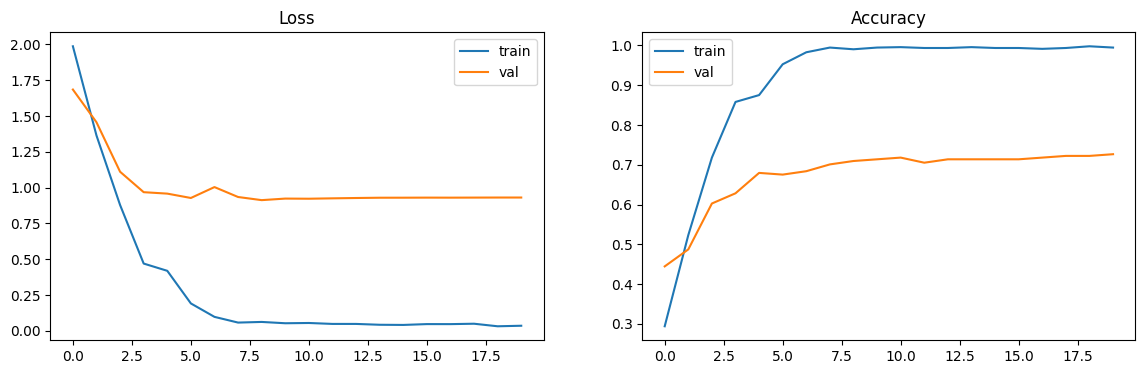

In [ ]:
plot_convergence(dict_res,num_epochs ); plt.show()

2. Second option: Transfering and freezing first 7 layers

In [ ]:
model_3,dict_res = train_model_3(model.to('cuda'), 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 2.2782 Acc: 0.2185
val Loss: 2.0639 Acc: 0.2479

Epoch 1/19
----------
train Loss: 2.0771 Acc: 0.2476
val Loss: 2.0573 Acc: 0.2479

Epoch 2/19
----------
train Loss: 2.0611 Acc: 0.2573
val Loss: 2.0647 Acc: 0.2479

Epoch 3/19
----------
train Loss: 2.0604 Acc: 0.2573
val Loss: 2.0499 Acc: 0.2479

Epoch 4/19
----------
train Loss: 2.0464 Acc: 0.2573
val Loss: 2.0366 Acc: 0.2479

Epoch 5/19
----------
train Loss: 2.0330 Acc: 0.2583
val Loss: 2.0255 Acc: 0.2479

Epoch 6/19
----------
train Loss: 2.0053 Acc: 0.2530
val Loss: 2.0259 Acc: 0.2479

Epoch 7/19
----------
train Loss: 1.9865 Acc: 0.2551
val Loss: 2.0029 Acc: 0.2479

Epoch 8/19
----------
train Loss: 1.9761 Acc: 0.2626
val Loss: 1.9935 Acc: 0.2650

Epoch 9/19
----------
train Loss: 1.9550 Acc: 0.2637
val Loss: 1.9861 Acc: 0.2906

Epoch 10/19
----------
train Loss: 1.9474 Acc: 0.2799
val Loss: 1.9814 Acc: 0.2949

Epoch 11/19
----------
train Loss: 1.9363 Acc: 0.2928
val Loss: 1.9787 Acc: 0.2863

Ep

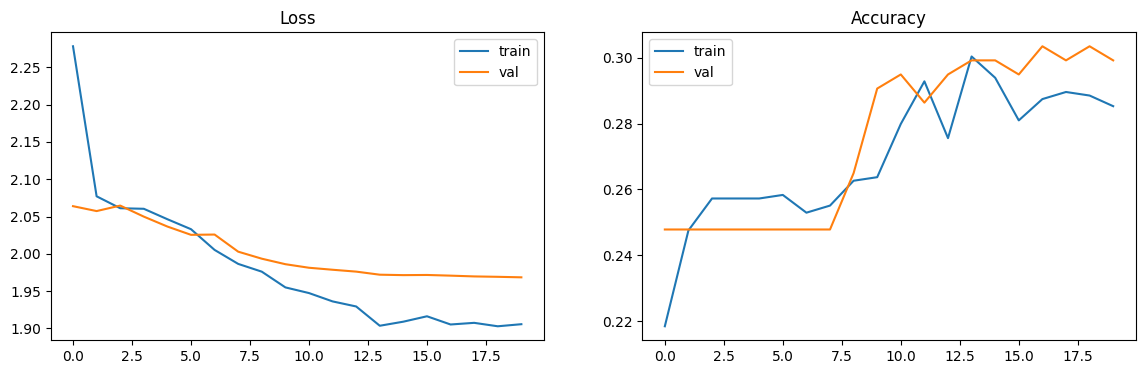

In [ ]:
plot_convergence(dict_res,num_epochs ); plt.show()

## Conclusions:
We can see that when we use transfer learning of the first layers with a randomly initiated network the model performs worst than in the previous section (when we transfer all layers and finetune the deeper layers). Furtheremore, we see that in this approach using more frozen layers results in much better acuracy, opposite to the previous section. When we froze 28 layers we got to acuracy of 0.726 compare to acuracy of 0.293 when we only transfer and froze the first 7 layers.

## (4) Using a model - only architecture (from scrach) (10 points)

In this part we will train the model from scrach. Means that we do not use a pre-trained weights at all, only "steal" the architecture of VGG16.

In [ ]:
# We load the model with rangdom weights

model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(in_features=4096, out_features=9) # update last layer to 9 classes
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# init model param
# we guess that we might need more epochs and maybe a larger lr:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 25


In [ ]:
# train the un-trained model:
%%time
model_4,dict_res = train_model(model.to('cuda'), 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 2.0942 Acc: 0.2411
val Loss: 2.0604 Acc: 0.2479

Epoch 1/24
----------
train Loss: 2.0697 Acc: 0.2551
val Loss: 2.0657 Acc: 0.2479

Epoch 2/24
----------
train Loss: 2.0611 Acc: 0.2551
val Loss: 2.1476 Acc: 0.2479

Epoch 3/24
----------
train Loss: 2.0737 Acc: 0.2551
val Loss: 2.0498 Acc: 0.2479

Epoch 4/24
----------
train Loss: 2.0352 Acc: 0.2551
val Loss: 2.0466 Acc: 0.2479

Epoch 5/24
----------
train Loss: 2.0251 Acc: 0.2573
val Loss: 2.0254 Acc: 0.2650

Epoch 6/24
----------
train Loss: 2.0134 Acc: 0.2551
val Loss: 2.0011 Acc: 0.2692

Epoch 7/24
----------
train Loss: 1.9569 Acc: 0.2670
val Loss: 1.9751 Acc: 0.2650

Epoch 8/24
----------
train Loss: 1.9387 Acc: 0.2799
val Loss: 1.9670 Acc: 0.2863

Epoch 9/24
----------
train Loss: 1.9200 Acc: 0.2928
val Loss: 1.9518 Acc: 0.2521

Epoch 10/24
----------
train Loss: 1.9002 Acc: 0.2853
val Loss: 1.9440 Acc: 0.2692

Epoch 11/24
----------
train Loss: 1.8835 Acc: 0.2971
val Loss: 1.9385 Acc: 0.2692

Ep

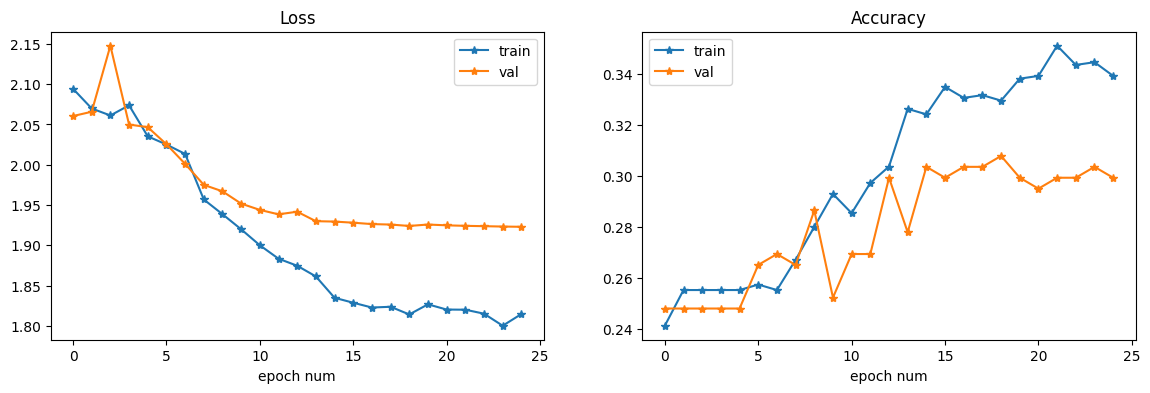

In [ ]:
# plot resutls
plot_convergence(dict_res,num_epochs); plt.show()

## Conclusions:
Here we can see that when we train from scratch the network results in a very poor acuracy, even when we let it train for more epochs. it might never reach the good results of pre-trained model since our data set it not big/quality enough.